## Multi-Aquifer Well Problem, Flowing Well Option

This is a modified version of the Neville-Tonkin Multi-Aquifer Well problem
from Neville and Tonkin, 2004 that uses the flowing well option.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-maw-p02"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 2  # Number of layers
nrow = 101  # Number of rows
ncol = 101  # Number of columns
delr = 142.0  # Column width ($m$)
delc = 142.0  # Row width ($m$)
top = -50.0  # Top of the model ($m$)
botm_str = "-142.9, -514.5"  # Bottom elevations ($m$)
strt_str = "3.05, 9.14"  # Starting head ($m$)
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
k33 = 1.0e-16  # Vertical hydraulic conductivity ($m/d$)
ss = 1e-4  # Specific storage ($1/d$)
maw_radius = 0.15  # Well radius ($m$)
maw_rate = 0.0  # Well pumping rate ($m^{3}/d$)

# parse parameter strings into tuples
botm = [float(value) for value in botm_str.split(",")]
strt = [float(value) for value in strt_str.split(",")]

# Static temporal data used by TDIS file
tdis_ds = ((2.314815, 50, 1.2),)

# Define dimensions
extents = (0.0, delr * ncol, 0.0, delc * nrow)
shape2d = (nrow, ncol)
shape3d = (nlay, nrow, ncol)

# create idomain
idomain = np.ones(shape3d, dtype=float)
xw, yw = (ncol / 2) * delr, (nrow / 2) * delc
y = 0.0
for i in range(nrow):
    x = 0.0
    y = (float(i) + 0.5) * delc
    for j in range(ncol):
        x = (float(j) + 0.5) * delr
        r = np.sqrt((x - xw) ** 2.0 + (y - yw) ** 2.0)
        if r > 7163.0:
            idomain[:, i, j] = 0

# MAW Package boundary conditions
maw_row = int(nrow / 2)
maw_col = int(ncol / 2)
maw_packagedata = [[0, maw_radius, botm[-1], strt[-1], "SPECIFIED", 2]]
maw_conn = [
    [0, 0, 0, maw_row, maw_col, top, botm[-1], 111.3763, -999.0],
    [0, 1, 1, maw_row, maw_col, top, botm[-1], 445.9849, -999.0],
]
maw_spd = [[0, "rate", maw_rate], [0, "flowing_well", 0.0, 7500.0, 0.5]]

# Solver parameters
nouter = 500
ninner = 100
hclose = 1e-9
rclose = 1e-4

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=0,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfsto(
        gwf,
        iconvert=0,
        ss=ss,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)

    maw = flopy.mf6.ModflowGwfmaw(
        gwf,
        flowing_wells=True,
        nmawwells=1,
        packagedata=maw_packagedata,
        connectiondata=maw_conn,
        perioddata=maw_spd,
    )
    obs_file = f"{sim_name}.maw.obs"
    csv_file = obs_file + ".csv"
    obs_dict = {
        csv_file: [
            ("head", "head", (0,)),
            ("Q1", "maw", (0,), (0,)),
            ("Q2", "maw", (0,), (1,)),
            ("FW", "fw-rate", (0,)),
        ]
    }
    maw.obs.initialize(
        filename=obs_file, digits=10, print_input=True, continuous=obs_dict
    )

    flopy.mf6.ModflowGwfoc(
        gwf,
        printrecord=[("BUDGET", "LAST")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Set figure properties specific to the
figure_size = (6.3, 4.3)
masked_values = (0, 1e30, -1e30)


def plot_maw_results(silent=True):
    with styles.USGSPlot():
        # load the observations
        fpth = os.path.join(workspace, sim_name, f"{sim_name}.maw.obs.csv")
        maw = flopy.utils.Mf6Obs(fpth).data

        time = maw["totim"] * 86400.0

        tmin = time[0]
        tmax = time[-1]

        # create the figure
        fig, axes = plt.subplots(
            ncols=1,
            nrows=2,
            sharex=True,
            figsize=figure_size,
            constrained_layout=True,
        )

        ax = axes[0]
        ax.set_xlim(tmin, tmax)
        ax.set_ylim(0, 4500)
        ax.semilogx(
            time,
            maw["Q1"],
            lw=0.75,
            ls="-",
            color="blue",
            label="Upper aquifer",
        )
        ax.semilogx(
            time,
            maw["Q2"],
            lw=0.75,
            ls="-",
            color="red",
            label="Lower aquifer",
        )
        ax.axhline(0, lw=0.5, color="0.5")
        ax.set_ylabel(" ")
        styles.heading(ax, idx=0)
        # styles.graph_legend(ax, loc="upper right", ncol=2)

        ax = axes[1]
        ax.set_xlim(tmin, tmax)
        ax.set_ylim(-4500, 0)
        ax.axhline(
            10.0,
            lw=0.75,
            ls="-",
            color="blue",
            label="Upper aquifer",
        )
        ax.axhline(
            10.0,
            lw=0.75,
            ls="-",
            color="red",
            label="Lower aquifer",
        )
        ax.semilogx(
            time,
            maw["FW"],
            lw=0.75,
            ls="-",
            color="black",
            label="Flowing well discharge",
        )
        ax.set_xlabel(" ")
        ax.set_ylabel(" ")
        for axis in (ax.xaxis,):
            axis.set_major_formatter(mpl.ticker.ScalarFormatter())
        styles.heading(ax, idx=1)
        styles.graph_legend(ax, loc="upper left", ncol=1)

        # add y-axis label that spans both subplots
        ax = fig.add_subplot(1, 1, 1)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # get rid of ticks and spines for legend area
        # ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)

        ax.set_xlabel("Simulation time, in seconds")
        ax.set_ylabel("Discharge rate, in cubic meters per day")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-01.png"
            fig.savefig(fpth)


def plot_grid(sim, silent=True):
    gwf = sim.get_model(sim_name)
    with styles.USGSMap():
        fig = plt.figure(
            figsize=(4, 4.3),
            tight_layout=True,
        )
        plt.axis("off")

        nrows, ncols = 10, 1
        axes = [fig.add_subplot(nrows, ncols, (1, 8))]

        for idx, ax in enumerate(axes):
            ax.set_xlim(extents[:2])
            ax.set_ylim(extents[2:])
            ax.set_aspect("equal")

        # legend axis
        axes.append(fig.add_subplot(nrows, ncols, (9, 10)))

        # set limits for legend area
        ax = axes[-1]
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # get rid of ticks and spines for legend area
        ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)

        ax = axes[0]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        mm.plot_bc("MAW", color="red")
        mm.plot_inactive(color_noflow="black")
        ax.set_xticks([0, extents[1] / 2, extents[1]])
        ax.set_yticks([0, extents[1] / 2, extents[1]])

        ax = axes[-1]
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="black",
            mec="black",
            markeredgewidth=0.5,
            label="Inactive cells",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="red",
            mec="red",
            markeredgewidth=0.5,
            label="Multi-aquifer well",
        )
        styles.graph_legend(ax, loc="lower center", ncol=2)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_results(sim, silent=True):
    plot_grid(sim, silent=silent)
    plot_maw_results(silent=silent)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 2305.54 ms


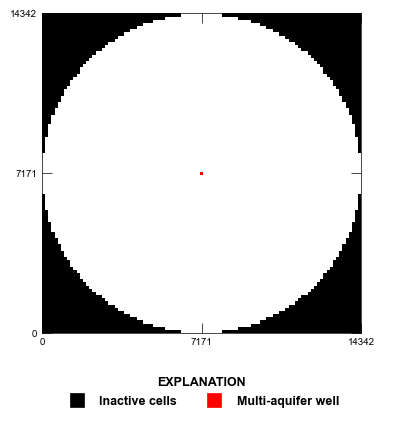

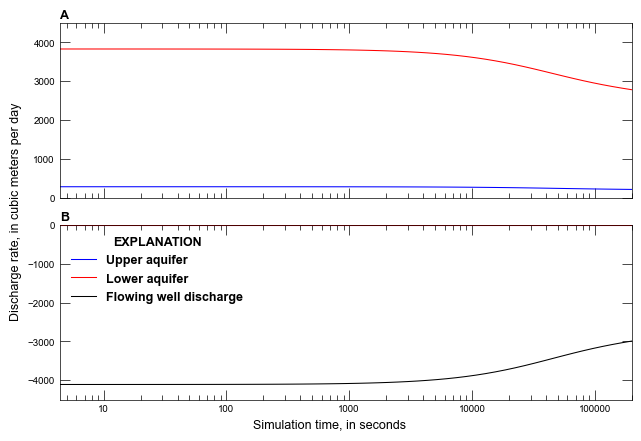

In [5]:
def scenario(silent=True):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)


scenario()